In [13]:
import itertools
import matplotlib.pyplot as plt
from collections import Counter
import csv
import json

In [14]:
# === Block 1: Define Board and Agent Base ===
import numpy as np

# Snake & ladder board mapping
board = {
    6: 16, 8: 41, 26: 29, 50: 93, 55: 80, 59: 84,
    32: 13, 60: 38, 63: 3, 70: 25, 73: 47,
    82: 43, 89: 53, 97: 12
}

# Helper: Apply board logic
def apply_board(pos, player, ladder_hits, snake_hits):
    if pos in board:
        if board[pos] > pos:
            ladder_hits[player] += 1
        elif board[pos] < pos:
            snake_hits[player] += 1
        return board[pos]
    return pos

In [15]:
# === Block 2: Define Agent Strategies (Extended) ===

import numpy as np

def roll_dice():
    """Roll a six-sided die (values 1-6)."""
    return np.random.randint(1, 7)

def maximizer_strategy(pos, board):
    """Always pick the higher of two dice rolls (greedy for distance)."""
    r1, r2 = roll_dice(), roll_dice()
    return max(r1, r2)

def minimizer_strategy(pos, board):
    """Always pick the lower of two dice rolls (cautious small steps)."""
    r1, r2 = roll_dice(), roll_dice()
    return min(r1, r2)

def smart_maximizer_strategy(pos, board):
    """
    Pick the dice roll that maximizes progress while avoiding snakes.
    Prioritizes ladders and avoids snakes if possible (a more strategic maximizer).
    """
    r1, r2 = roll_dice(), roll_dice()
    c1, c2 = pos + r1, pos + r2
    b1, b2 = board.get(c1, c1), board.get(c2, c2)  # new positions after applying snakes/ladders
    # If one roll lands on a ladder and the other doesn't, take the ladder
    if b1 > c1 and b2 <= c2:
        return r1
    if b2 > c2 and b1 <= c1:
        return r2
    # If one roll lands on a snake and the other doesn't, avoid the snake
    if c1 in board and board[c1] < c1 and not (c2 in board and board[c2] < c2):
        return r2
    if c2 in board and board[c2] < c2 and not (c1 in board and board[c1] < c1):
        return r1
    # If both rolls land on ladders, take the one that climbs higher
    if b1 > c1 and b2 > c2:
        return r1 if b1 >= b2 else r2
    # If both rolls land on snakes, take the one with a smaller drop (less harmful snake)
    if b1 < c1 and b2 < c2:
        # Compare how far each snake sends the player back
        drop1 = c1 - b1  # how much snake 1 drops
        drop2 = c2 - b2  # how much snake 2 drops
        return r1 if drop1 <= drop2 else r2
    # If no special cases (no snakes or ladders involved), just pick the larger roll
    return max(r1, r2)

def skipper_strategy(pos, board):
    """
    Roll one die. If the move would land on a snake, skip this turn (return 0) to avoid it.
    Otherwise, proceed with the roll.
    """
    r = roll_dice()
    new_pos = pos + r
    # If landing on a snake (new position is a key in board and goes downward)
    if new_pos in board and board[new_pos] < new_pos:
        return 0  # skip this turn to avoid snake
    return r

def bounded_skipper_strategy(pos, board, skip_count):
    """
    Similar to skipper_strategy, but will not skip more than 3 times in a row.
    Uses skip_count to track consecutive skips.
    Returns a tuple: (chosen_roll, new_skip_count).
    """
    # If already skipped 3 times consecutively, force a move
    if skip_count >= 3:
        r = roll_dice()
        return r, 0  # take this roll and reset skip_count
    r = roll_dice()
    new_pos = pos + r
    if new_pos in board and board[new_pos] < new_pos:
        # Landing on a snake, so skip and increment skip_count
        return 0, skip_count + 1
    # Safe or ladder move, so take it and reset skip_count
    return r, 0

# --- New Strategies ---

def ladder_seeker_strategy(pos, board):
    """
    Always chase ladders. Roll two dice and choose the outcome that lands on a ladder if possible.
    If neither lands on a ladder (or both do), pick the option that yields the furthest progress.
    """
    r1, r2 = roll_dice(), roll_dice()
    c1, c2 = pos + r1, pos + r2
    # Check if landing on ladder for each outcome
    ladder1 = (c1 in board and board[c1] > c1)
    ladder2 = (c2 in board and board[c2] > c2)
    if ladder1 and not ladder2:
        return r1  # first roll lands on a ladder, second does not
    if ladder2 and not ladder1:
        return r2  # second roll lands on a ladder, first does not
    if ladder1 and ladder2:
        # Both rolls land on ladders: choose the one that goes higher
        new1, new2 = board[c1], board[c2]
        return r1 if new1 >= new2 else r2
    # No ladders from either roll: just take the larger roll (maximize progress)
    return r1 if r1 >= r2 else r2

def snake_avoider_strategy(pos, board):
    """
    Avoid snakes at all costs. Roll two dice and choose the outcome that does NOT land on a snake.
    If both outcomes land on snakes, take the lesser penalty. Otherwise, if neither is a snake, take the larger roll.
    """
    r1, r2 = roll_dice(), roll_dice()
    c1, c2 = pos + r1, pos + r2
    snake1 = (c1 in board and board[c1] < c1)  # True if roll1 lands on a snake
    snake2 = (c2 in board and board[c2] < c2)  # True if roll2 lands on a snake
    if snake1 and not snake2:
        return r2  # avoid the snake from roll1
    if snake2 and not snake1:
        return r1  # avoid the snake from roll2
    if snake1 and snake2:
        # Both rolls hit snakes: choose the one with smaller drop
        drop1 = c1 - board[c1]
        drop2 = c2 - board[c2]
        return r1 if drop1 <= drop2 else r2
    # No snake on either roll: take the larger outcome (no immediate risk)
    return r1 if r1 >= r2 else r2

def random_choice_strategy(pos, board):
    """
    Let fate decide. Roll two dice and choose one of them at random, without bias toward high or low.
    """
    r1, r2 = roll_dice(), roll_dice()
    # Randomly pick one of the two outcomes
    if np.random.rand() < 0.5:
        return r1
    else:
        return r2

def always_first_strategy(pos, board):
    """
    First impulse only. Roll two dice but always use the first roll, ignoring the second completely.
    """
    r1 = roll_dice()
    _ = roll_dice()  # second roll (ignored)
    return r1

def always_second_strategy(pos, board):
    """
    Always second guess. Roll two dice but always take the second roll, disregarding the first.
    """
    _ = roll_dice()   # first roll (ignored)
    r2 = roll_dice()  # second roll (used)
    return r2

def steady_climber_strategy(pos, board):
    """
    Avoid extreme jumps. Roll two dice and choose the smaller if the difference is large (>=4),
    otherwise choose the larger. (Prefers moderate steady progress.)
    """
    r1, r2 = roll_dice(), roll_dice()
    # Determine the difference between the two outcomes
    diff = abs(r1 - r2)
    if diff >= 4:
        # If outcomes differ a lot, take the smaller value for a steady move
        return min(r1, r2)
    else:
        # If outcomes are close, take the larger value (no huge risk in either)
        return max(r1, r2)

def impatient_strategy(pos, board):
    """
    No small steps. Roll one die; if the result is 1, 2, or 3, skip the turn (return 0) hoping for a bigger roll next time.
    If it's 4, 5, or 6, take the roll. (Impatient for big moves.)
    """
    r = roll_dice()
    if r <= 3:
        return 0  # skip small rolls
    return r  # take the big roll (4-6)

def gambler_strategy(pos, board):
    """
    Take a risk with a second chance. Roll one die first:
    - If it results in a ladder or a high number (5 or 6) and not a snake, keep it.
    - Otherwise (low roll or snake), 'gamble' by rolling a second die and use the second result (ignoring the first).
    """
    r1 = roll_dice()
    c1 = pos + r1
    # Determine if first roll hits snake or ladder
    ladder1 = (c1 in board and board[c1] > c1)
    snake1 = (c1 in board and board[c1] < c1)
    if ladder1 or (r1 >= 5 and not snake1):
        # Good outcome (ladder or high safe roll), keep r1
        return r1
    else:
        # Otherwise, take a chance on a second roll
        r2 = roll_dice()
        return r2

def adaptive_strategy(pos, board):
    """
    Change behavior based on progress:
    - If in early game (before halfway point), play aggressively (prefer ladders and larger rolls).
    - If in late game (after halfway), play cautiously (avoid snakes and prefer smaller safe rolls).
    """
    board_size = 100  # assuming standard board size of 100
    halfway = board_size // 2
    r1, r2 = roll_dice(), roll_dice()
    c1, c2 = pos + r1, pos + r2
    # Early game (aggressive play)
    if pos < halfway:
        # If one leads to a ladder, take it; otherwise take the larger roll
        ladder1 = (c1 in board and board[c1] > c1)
        ladder2 = (c2 in board and board[c2] > c2)
        if ladder1 and not ladder2:
            return r1
        if ladder2 and not ladder1:
            return r2
        # If neither leads to a ladder (or both do), just take the bigger roll
        return r1 if r1 >= r2 else r2
    # Late game (cautious play)
    else:
        snake1 = (c1 in board and board[c1] < c1)
        snake2 = (c2 in board and board[c2] < c2)
        # Avoid snake outcomes if possible
        if snake1 and not snake2:
            return r2
        if snake2 and not snake1:
            return r1
        # No snakes (or both have snakes): take the smaller roll for safety
        return r1 if r1 <= r2 else r2

def ladder_waiter_strategy(pos, board):
    """
    Wait for that ladder! Roll one die. If a ladder is within 6 steps and the roll does NOT land on it, skip this turn (return 0) to try again next turn.
    If the roll lands on a ladder (or no ladder is in immediate range), take the roll.
    """
    r = roll_dice()
    # Find any ladder within the next 6 positions
    ladder_in_range = False
    target_step = None
    for step in range(1, 7):
        new_pos = pos + step
        if new_pos in board and board[new_pos] > new_pos:
            ladder_in_range = True
            # Choose the ladder that is nearest (smallest step) or you could choose the biggest jump; here we just pick the first found
            target_step = step
            break
    if ladder_in_range:
        # If current roll hits the ladder exactly, take it; otherwise skip to wait for the ladder
        if r == target_step:
            return r  # we rolled exactly the number needed for the ladder
        else:
            return 0   # skip this turn to try for the ladder next time
    else:
        # No ladder nearby, just take the roll normally
        return r

def bounded_ladder_waiter_strategy(pos, board, skip_count):
    """
    Similar to ladder_waiter_strategy, but will not wait forever for a ladder.
    Skips to try for a ladder if one is close, but after 3 consecutive skips, it will take the next roll regardless.
    Returns a tuple: (chosen_roll, new_skip_count).
    """
    # Determine if a ladder is within reach (next 6 steps) and the exact roll needed for it
    ladder_in_range = False
    target_step = None
    for step in range(1, 7):
        new_pos = pos + step
        if new_pos in board and board[new_pos] > new_pos:
            ladder_in_range = True
            target_step = step
            break
    # If already skipped 3 times waiting, just roll and move (stop waiting)
    if skip_count >= 3:
        r = roll_dice()
        return r, 0  # reset skip_count after forcing a move
    r = roll_dice()
    if ladder_in_range:
        if r == target_step:
            # We got the exact roll for the ladder
            return r, 0  # take it and reset skip_count
        else:
            # Not the number we need for the ladder, skip this turn and increment skip_count
            return 0, skip_count + 1
    else:
        # No ladder in range, take the roll normally
        return r, 0


In [20]:
import random
import multiprocessing

# === Block 3: Tournament Logic ===
def play_game(agent1, agent2, name1, name2):
    pos         = [0, 0]
    turns       = 0
    skip_cnt    = {name1: 0, name2: 0}
    ladder_hits = [0, 0]
    snake_hits  = [0, 0]
    seq         = []
    player      = 0

    while max(pos) < 100:
        name = name1 if player == 0 else name2
        strat = agent1 if player == 0 else agent2

        # FIX: handle all agents that require skip_count
        if "bounded_skipper" in name or "bounded_ladder_waiter" in name:
            roll, new_skip = strat(pos[player], board, skip_cnt[name])
            skip_cnt[name] = new_skip
        else:
            roll = strat(pos[player], board)

        if roll == 0:
            seq.append(f"{name}|skip")
        else:
            pos[player] += roll
            pos[player] = apply_board(pos[player], player, ladder_hits, snake_hits)
            seq.append(f"{name}|{roll}->{pos[player]}")

        turns += 1
        player = 1 - player

    winner_index = 0 if pos[0] >= 100 else 1
    return winner_index, turns, ";".join(seq)



def run_single_tournament(agent_pool):
    """
    One 16-player tournament:
      • 4 groups of 4 → round-robin
      • Top 2 per group → 8 → quarter-finals
      • 4 → semi-finals → 2 → final
    Returns {"champion": str, "matches": [ ... ]}
    """
    names = list(agent_pool.keys())
    random.shuffle(names)

    # 1) Assign 4 groups of 4
    groups = {}
    idx = 0
    for gi in range(1, 5):
        groups[f"Group{gi}"] = names[idx: idx + 4]
        idx += 4

    matches = []
    advancers = []

    # 2) Group stage round-robin
    for grp, players in groups.items():
        for p1, p2 in itertools.combinations(players, 2):
            w_idx, turns, seq = play_game(agent_pool[p1], agent_pool[p2], p1, p2)
            winner = p1 if w_idx == 0 else p2
            matches.append({
                "tournament_round": "Group",
                "group": grp,
                "player1": p1,
                "player2": p2,
                "winner":  winner,
                "turns":   turns,
                "sequence": seq
            })
        # pick top 2 by win count
        win_counts = Counter(
            m["winner"]
            for m in matches
            if m["tournament_round"] == "Group" and m["group"] == grp
        )
        ranked = sorted(players, key=lambda p: win_counts[p], reverse=True)
        advancers.extend(ranked[:2])

    # 3) Quarter-finals (8 → 4)
    random.shuffle(advancers)
    qf_pairs = [(advancers[i], advancers[i+1]) for i in range(0, 8, 2)]
    qf_winners = []
    for p1, p2 in qf_pairs:
        w_idx, turns, seq = play_game(agent_pool[p1], agent_pool[p2], p1, p2)
        winner = p1 if w_idx == 0 else p2
        qf_winners.append(winner)
        matches.append({
            "tournament_round": "Quarter",
            "group":    None,
            "player1":  p1,
            "player2":  p2,
            "winner":   winner,
            "turns":    turns,
            "sequence": seq
        })

    # 4) Semi-finals (4 → 2)
    random.shuffle(qf_winners)
    sf_pairs = [(qf_winners[0], qf_winners[1]), (qf_winners[2], qf_winners[3])]
    sf_winners = []
    for p1, p2 in sf_pairs:
        w_idx, turns, seq = play_game(agent_pool[p1], agent_pool[p2], p1, p2)
        winner = p1 if w_idx == 0 else p2
        sf_winners.append(winner)
        matches.append({
            "tournament_round": "Semi",
            "group":    None,
            "player1":  p1,
            "player2":  p2,
            "winner":   winner,
            "turns":    turns,
            "sequence": seq
        })

    # 5) Final (2 → Champion)
    f1, f2 = sf_winners
    w_idx, turns, seq = play_game(agent_pool[f1], agent_pool[f2], f1, f2)
    champion = f1 if w_idx == 0 else f2
    matches.append({
        "tournament_round": "Final",
        "group":    None,
        "player1":  f1,
        "player2":  f2,
        "winner":   champion,
        "turns":    turns,
        "sequence": seq
    })

    return {"champion": champion, "matches": matches}

In [17]:

def run_tournaments(agent_pool, n_tournaments=100_000):
    """
    Parallelize run_single_tournament over n_tournaments using starmap.
    """
    # Prepare starmap args: a list of (agent_pool,) tuples
    tasks = [(agent_pool,) for _ in range(n_tournaments)]
    n_workers = multiprocessing.cpu_count()

    with multiprocessing.Pool(processes=n_workers) as pool:
        results = pool.starmap(run_single_tournament, tasks)

    for idx, res in enumerate(results, start=1):
        res["tournament"] = idx

    return results


In [18]:
def summarize_tournament(records):
    champions = [r["champion"] for r in records]
    counter = Counter(champions)

    print(f"\nChampion Win Counts (out of {len(records)} tournaments):")
    for agent, count in counter.most_common():
        print(f"{agent}: {count} wins")

    plt.figure(figsize=(6, 6))
    plt.pie(counter.values(), labels=counter.keys(), autopct='%1.1f%%', startangle=140)
    plt.title("Tournament Champion Distribution")
    plt.show()

    return counter


Champion Win Counts (out of 100000 tournaments):
smart_maximizer: 32275 wins
adaptive: 13401 wins
ladder_seeker: 12797 wins
snake_avoider: 12689 wins
gambler: 9475 wins
skipper: 5588 wins
bounded_skipper: 5480 wins
maximizer: 3042 wins
steady_climber: 1339 wins
always_second: 1072 wins
always_first: 1047 wins
random_choice: 1004 wins
bounded_ladder_waiter: 368 wins
ladder_waiter: 256 wins
minimizer: 134 wins
impatient: 33 wins


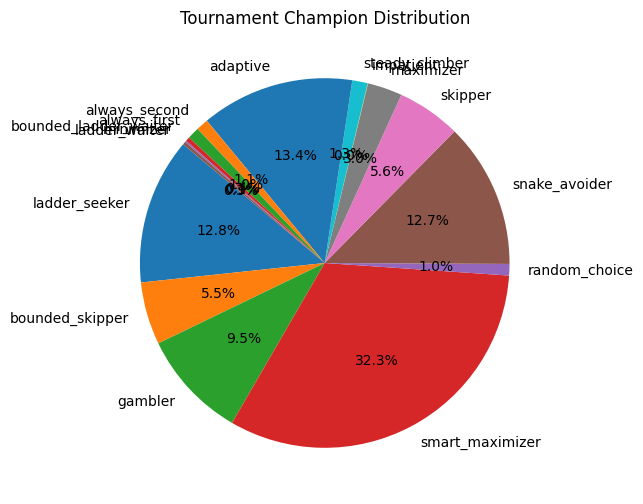

In [21]:
agent_pool = {
        "maximizer": maximizer_strategy,
        "minimizer": minimizer_strategy,
        "smart_maximizer": smart_maximizer_strategy,
        "skipper": skipper_strategy,
        "bounded_skipper": bounded_skipper_strategy,
        "ladder_seeker": ladder_seeker_strategy,
        "snake_avoider": snake_avoider_strategy,
        "random_choice": random_choice_strategy,
        "always_first": always_first_strategy,
        "always_second": always_second_strategy,
        "steady_climber": steady_climber_strategy,
        "impatient": impatient_strategy,
        "gambler": gambler_strategy,
        "adaptive": adaptive_strategy,
        "ladder_waiter": ladder_waiter_strategy,
        "bounded_ladder_waiter": bounded_ladder_waiter_strategy,
    }

# run 100k tournaments in parallel
records = run_tournaments(agent_pool, n_tournaments=100_000)
summary = summarize_tournament(records)

In [22]:
import csv

def export_tournament_csv(records, filename="tournament_results.csv"):
    with open(filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "Tournament", "Round", "Group",
            "Player 1", "Player 2",
            "Winner", "Turns", "Sequence"
        ])
        for rec in records:
            tnum = rec["tournament"]
            for m in rec["matches"]:
                writer.writerow([
                    tnum,
                    m["tournament_round"],
                    m["group"] or "",
                    m["player1"],
                    m["player2"],
                    m["winner"],
                    m["turns"],
                    m["sequence"]
                ])

# call when ready
export_tournament_csv(records)

In [23]:
import zipfile
import os

# Path to your CSV
csv_path = "/content/tournament_results.csv"
zip_path = "/content/tournament_results.zip"

# Compress to ZIP
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_path, arcname=os.path.basename(csv_path))

# Show download link
from google.colab import files
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import zipfile
import os
import shutil

# Paths
csv_path = "/content/tournament_results.csv"
zip_path = "/content/tournament_results.zip"
drive_zip_path = "/content/drive/MyDrive/RedesignSAL/tournament_results.zip"

# Step 1: Compress the CSV to a zip file
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_path, arcname=os.path.basename(csv_path))

# Step 2: Move the zip to Google Drive
shutil.move(zip_path, drive_zip_path)

print(f"✅ Zipped file moved to: {drive_zip_path}")


✅ Zipped file moved to: /content/drive/MyDrive/RedesignSAL/tournament_results.zip


In [ ]:
# === Block 6: Export Tournament Summary to JSON ===
def export_tournament_json(records, filename="tournament_summary.json"):
    tournament_summary = []

    for record in records:
        tournament_id = record["tournament"]
        match_log = record["matches"]
        final_match = match_log[-1]
        semifinal_matches = match_log[-3:-1]
        round1_matches = match_log[:-3]

        finalists = set([final_match[0], final_match[1]])
        semi_finalists = set([m[0] for m in semifinal_matches] + [m[1] for m in semifinal_matches])
        round1_players = set([m[0] for m in round1_matches] + [m[1] for m in round1_matches])

        semifinal_losers = semi_finalists - set([final_match[2]])
        round1_losers = round1_players - semi_finalists

        tournament_summary.append({
            "tournament": tournament_id,
            "champion": final_match[2],
            "runner_up": final_match[1] if final_match[2] == final_match[0] else final_match[0],
            "third_places": list(semifinal_losers),
            "eliminated_in_round1": list(round1_losers),
            "matches": [
                {
                    "round": "Round 1" if i < 10 else ("Semifinal" if i < 12 else "Final"),
                    "player_1": m[0],
                    "player_2": m[1],
                    "winner": m[2],
                    "turns": m[3]
                }
                for i, m in enumerate(match_log)
            ]
        })

    with open(filename, 'w') as f:
        json.dump(tournament_summary, f, indent=4)

    print(f"Exported detailed tournament data to {filename}")


In [ ]:
export_tournament_csv(records)

Exported detailed tournament data to tournament_summary.json
